# Halo Spectroscopy of Ceres

Let's apply the halo photometry ideas that worked so successfully in K2, to IFU spectroscopy of a saturated source observed with MIRI: Ceres. The core of its PSF is saturated, but the surrounding spaxels seem to be ok.

First, import everything we need.

In [1]:
import jax.numpy as np
import matplotlib.pyplot as plt
import numpy as onp

import jax 

from astropy.io import fits

from glob import glob

import halospec.objectives as obj

import jaxopt

from matplotlib.widgets import Slider

jax.config.update("jax_enable_x64", True)

%matplotlib inline


In [2]:
ls ../data/MAST_2024-07-05T0101/JWST

/Users/benpope/opt/anaconda3/envs/halospec/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


jw01245-o004_t001_miri_ch1-shortmediumlong/
jw01245-o004_t001_miri_ch2-shortmediumlong/
jw01245-o004_t001_miri_ch3-shortmediumlong/
jw01245-o004_t001_miri_ch4-shortmediumlong/
jw01245-o021_t002_miri_ch1-shortmediumlong/
jw01245-o021_t002_miri_ch2-shortmediumlong/
jw01245-o021_t002_miri_ch3-shortmediumlong/
jw01245-o021_t002_miri_ch4-shortmediumlong/
jw01245-o024_t003_miri_ch1-shortmediumlong/
jw01245-o024_t003_miri_ch2-shortmediumlong/
jw01245-o024_t003_miri_ch3-shortmediumlong/
jw01245-o024_t003_miri_ch4-shortmediumlong/
jw01245040001_03102_00001_nrcblong/


Which sources did we get in this download?

In [3]:
ddir = '../data/MAST_2024-07-05T0101/JWST/'# unsaturated
ddir = '../data/MAST_2024-07-05T0131/JWST/' # saturated 
datasets = glob(ddir+'*')
# print(datasets)

# figure out which targets are which
for j, dataset in enumerate(datasets):
    try:
        ifu = glob(dataset+'/*s3d*')
        hdr = fits.getheader(ifu[0])
        name = hdr['OBSLABEL']
        print(j, name)
    except:
        print(j,'--')

0 Hygiea/MIRI Background
1 Ceres/MIRI
2 --
3 Didymos/MIRI
4 Didymos/MIRI
5 Didymos/MIRI Background
6 Pallas/MIRI
7 Ceres/MIRI
8 Hygiea/MIRI Background
9 Pallas/MIRI Background
10 Hygiea/MIRI Background
11 Ceres/MIRI Background
12 Hygiea/MIRI
13 Phaethon/MIRI
14 Ceres/MIRI
15 Didymos/MIRI
16 Pallas/MIRI
17 Didymos/MIRI Background
18 Hygiea/MIRI
19 Ceres/MIRI Background
20 Phaethon/MIRI
21 Pallas/MIRI Background
22 Pallas/MIRI Background
23 Phaethon/MIRI
24 Ceres/MIRI Background
25 Hygiea/MIRI
26 Ceres/MIRI
27 Phaethon/MIRI
28 Hygiea/MIRI
29 Ceres/MIRI Background
30 Didymos/MIRI Background
31 Didymos/MIRI
32 Pallas/MIRI
33 --
34 Pallas/MIRI
35 Didymos/MIRI Background
36 Hygiea/MIRI Background
37 Pallas/MIRI Background


Load Ceres.

In [4]:
# dataset = ddir + 'jw01244-o024_t003_miri_ch4-shortmediumlong/'

index = 1 # Ceres
dataset = datasets[index]+'/'
# print(dataset)

ifu = glob(dataset+'*s3d*')
print('IFU Filename',ifu[0])
# print(files)

extracted = glob(dataset+'*x1d*')
print('Extracted Spectrum filename',extracted[0])
extracted_hdr = fits.getheader(extracted[0],ext=1)

hdu = fits.open(ifu[0])
data = fits.getdata(ifu[0])
data[~onp.isfinite(data)] = 0 # set NaNs to 0

hdr = fits.getheader(ifu[0])
name = hdr['OBSLABEL']

extracted = glob(dataset+'*x1d*')
extracted_hdr = fits.getheader(extracted[0],ext=1)
extracted_data = fits.getdata(extracted[0],ext=1)
wavels, ext_spec = extracted_data['WAVELENGTH'], extracted_data['FLUX']
ext_spec /= onp.nanmedian(ext_spec)

print('\nTarget:',name)

IFU Filename ../data/MAST_2024-07-05T0131/JWST/jw01244-o022_t001_miri_ch3-shortmediumlong/jw01244-o022_t001_miri_ch3-shortmediumlong_s3d.fits
Extracted Spectrum filename ../data/MAST_2024-07-05T0131/JWST/jw01244-o022_t001_miri_ch3-shortmediumlong/jw01244-o022_t001_miri_ch3-shortmediumlong_x1d.fits

Target: Ceres/MIRI


Visualize a slice: what does one frame look like?

Text(0.5, 1.0, 'Zero')

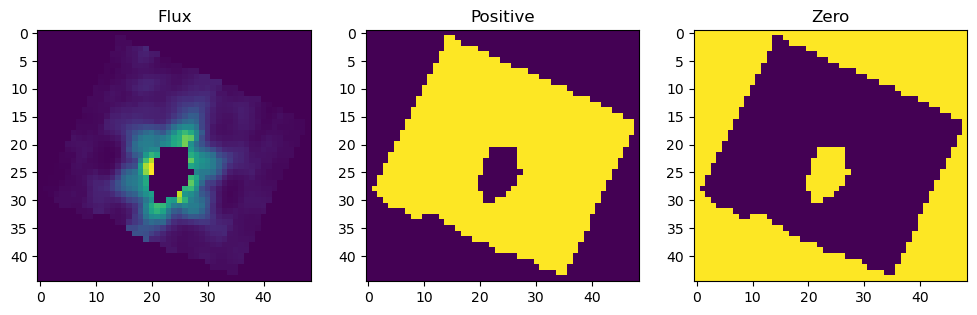

In [5]:
# one frame
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12.0,4.0))

data[data==np.nan] = 0

ax1.imshow(data[0,:,:])
ax1.set_title('Flux')

ax2.imshow(data[0,:,:]>0)
ax2.set_title('Positive')

ax3.imshow(data[0,:,:]==0)
ax3.set_title('Zero')

(Interactively visualize a slice)

In [ ]:
# %matplotlib widget 
# idx0 = 3
# l = plt.imshow(data[idx0])

# axidx = plt.axes([0.25, 0.01, 0.65, 0.03])
# slidx = Slider(axidx, 'index', 0, 9, valinit=idx0, valfmt='%d')

# def update(val):
#     idx = slidx.val
#     l.set_data(data[int(idx)])
#     fig.canvas.draw_idle()
    
# slidx.on_changed(update)

# plt.show()


What does the median frame look like?

Text(0.5, 1.0, 'Zero')

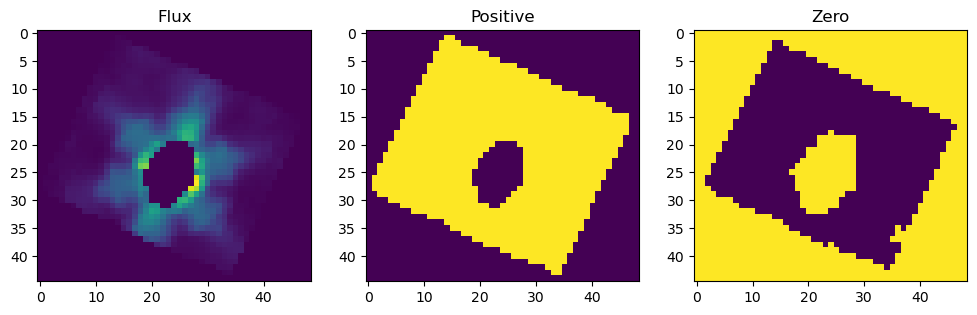

In [6]:
%matplotlib inline

# all frames
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12.0,4.0))

ax1.imshow(onp.median(data,axis=0))
ax1.set_title('Flux')

ax2.imshow(onp.median(data,axis=0)>0)
ax2.set_title('Positive')

ax3.imshow(onp.min(data,axis=0)==0)
ax3.set_title('Zero')

So they are using zero-masking. That's good!

Let's identify bad frames, and saturated / missing pixels.

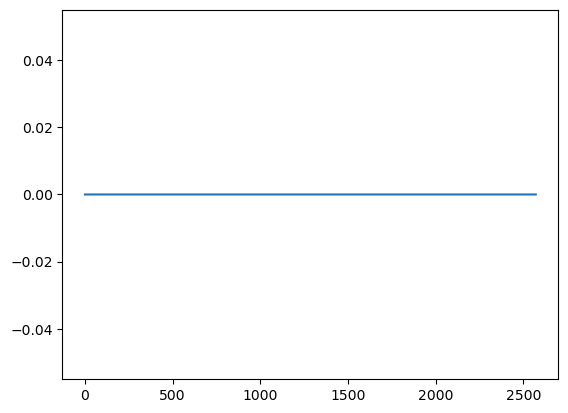

In [7]:
# ravel pixels
ravelled = np.reshape(data,(data.shape[0],data.shape[1]*data.shape[2]))
plt.plot(onp.min(ravelled,axis=1)) # some frames are badly corrected?

In [8]:
# frame rejection
goodframes = onp.min(ravelled,axis=1)==0

# pixel rejection
goodpix = onp.min(data,axis=0)>0

# censored data
newdata = data[:,goodpix]
newdata = newdata[goodframes]

wavels, ext_spec = wavels[goodframes],ext_spec[goodframes]
print('Shape of censored data in spectra x spaxels:',newdata.shape)

Shape of censored data in spectra x spaxels: (2572, 920)


Now let's plot a selection of individual spectra, and their total and the pipeline extracted spectrum.

Text(0.5, 0, 'Wavelength (μm)')

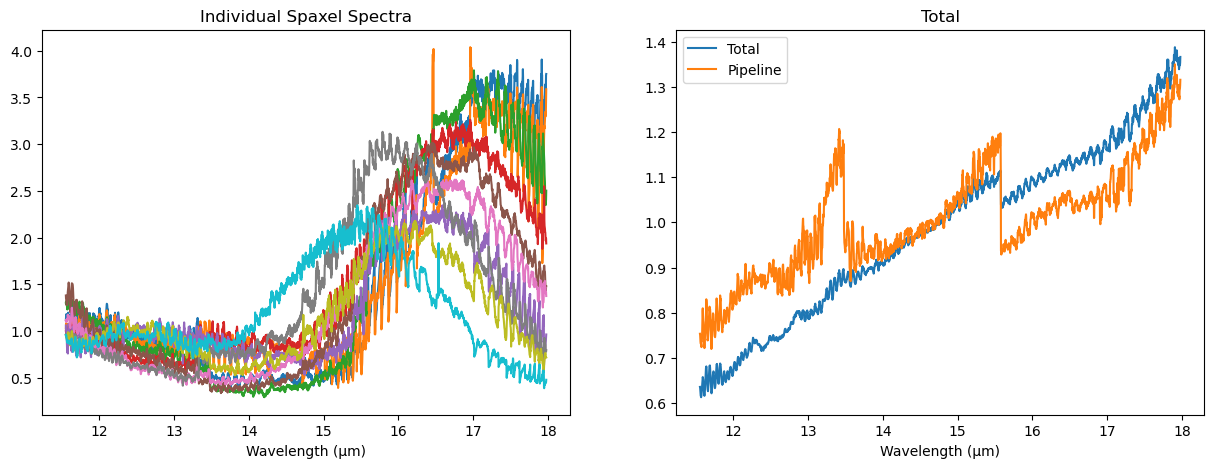

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15.0,5.0))
for j in range(10):
    spec = newdata[:,j]
    ax1.plot(wavels,spec/onp.nanmedian(spec))
ax1.set_title('Individual Spaxel Spectra')
ax1.set_xlabel('Wavelength (μm)')
    
flat = onp.sum(newdata,axis=1)
flat /= onp.nanmedian(flat)
ax2.plot(wavels,flat,label='Total')
ax2.plot(wavels,ext_spec,label='Pipeline')
plt.legend()

ax2.set_title('Total')
ax2.set_xlabel('Wavelength (μm)')


# Now let's do a TV-min spectral extraction.

We will compare the classic TV-min algorithm from [White et al, 2017](https://ui.adsabs.harvard.edu/abs/2017MNRAS.471.2882W/abstract) to L2 and standard-deviation-optimization algorithms. 

In [10]:
from jaxopt import LBFGS
make_spec = obj.make_spec

In [11]:
spaxels = np.array(newdata).T # make it a jax array of the right shape

In [12]:
%%time

# TV-Min - minimize L1 norm of gradient - same as in halo
tvmin = lambda x: obj.tv(x,1,spaxels) # not using lag so setting it to 1 by lambda function

init_params = 1.0*np.ones(newdata.shape[1]) # shape is (wavels,spaxels)

solver = jaxopt.LBFGS(fun=tvmin, maxiter=100)
res = solver.run(init_params)
tv_params, state = res

tv_final = make_spec(tv_params,spaxels)

CPU times: user 2.24 s, sys: 151 ms, total: 2.39 s
Wall time: 2.41 s


... and L2V-min, or maximum smoothness:

In [13]:
%%time

# L2V-Min - minimize L2 norm of gradient, ie maximize smoothness
l2vmin = lambda x: obj.l2v(x,1,spaxels) # not using lag so setting it to 1 by lambda function

init_params = 1.0*np.ones(newdata.shape[1]) # shape is (wavels,spaxels)

solver = jaxopt.LBFGS(fun=l2vmin, maxiter=100)
res = solver.run(init_params)
l2v_params, state = res

l2v_final = make_spec(l2v_params,spaxels)

CPU times: user 1.59 s, sys: 117 ms, total: 1.7 s
Wall time: 1.68 s


And we can try [OWL](https://github.com/davidwhogg/OWL), for completeness' sake using all the original halo objectives:

In [14]:
%%time
# OWL - from https://github.com/davidwhogg/OWL using standard deviation as the objective. 
# It doesn't seem to do especially well!

owlvmin = lambda x: obj.owl(x,spaxels)

init_params = 1.0*np.ones(newdata.shape[1]) # shape is (wavels,spaxels)

solver = jaxopt.LBFGS(fun=owlvmin, maxiter=100)
res = solver.run(init_params)
owl_params, state = res

owl_final = make_spec(owl_params,spaxels)

CPU times: user 3.01 s, sys: 134 ms, total: 3.14 s
Wall time: 3.15 s


Experimental Gaussian Process model:

In [15]:
%%time
# GP log likelihood as objective function. 

gpmin = lambda x: obj.gp(x,spaxels,np.array(wavels))

init_params = 1.0*np.ones(newdata.shape[1]) # shape is (wavels,spaxels)

solver = jaxopt.LBFGS(fun=gpmin, maxiter=100)
res = solver.run(init_params)
gp_params, state = res

gp_final = make_spec(gp_params,spaxels)

CPU times: user 2.95 s, sys: 460 ms, total: 3.41 s
Wall time: 3.06 s


And with uniform weights:

In [16]:
# what does a direct sum look like
uniform = make_spec(init_params,spaxels)

Plot these:

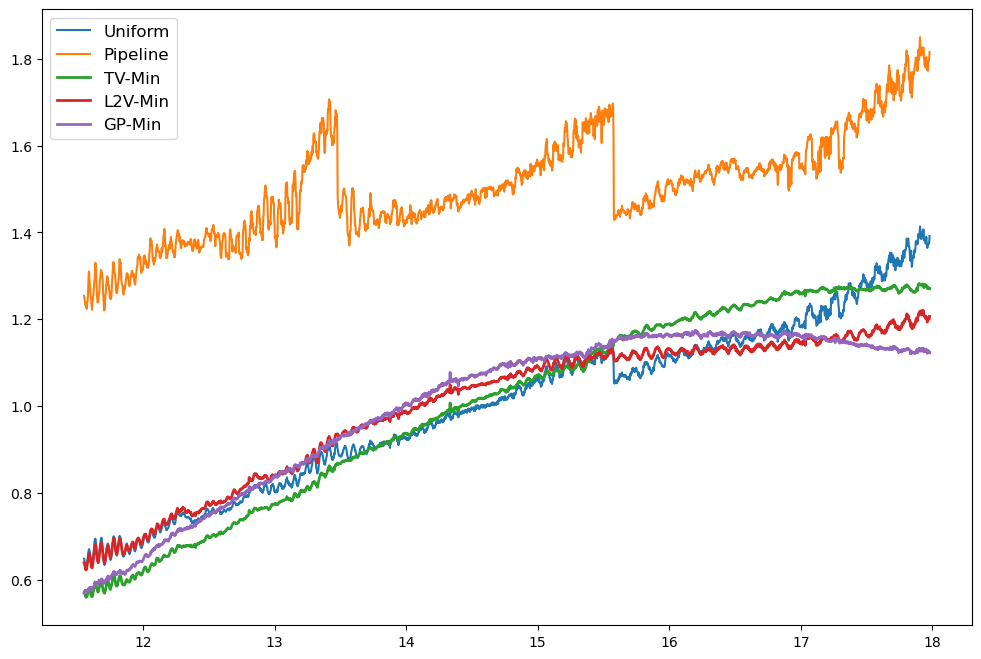

In [17]:
fig = plt.figure(figsize=(12.0,8.0))

plt.plot(wavels,uniform,label='Uniform')
plt.plot(wavels,ext_spec+0.5,label='Pipeline')


plt.plot(wavels,tv_final,label='TV-Min',lw=2)
plt.plot(wavels,l2v_final,label='L2V-Min',lw=2)
plt.plot(wavels,gp_final,label='GP-Min',lw=2)

# plt.plot(wavels,owl_final,label='OWL',lw=2)


plt.legend(fontsize=12)

So the optimized spectra don't look a lot better than with uniform weights, and none of them closely resemble the pipeline spectrum (which may be a feature, not a bug!).

## Visualize the Weight map

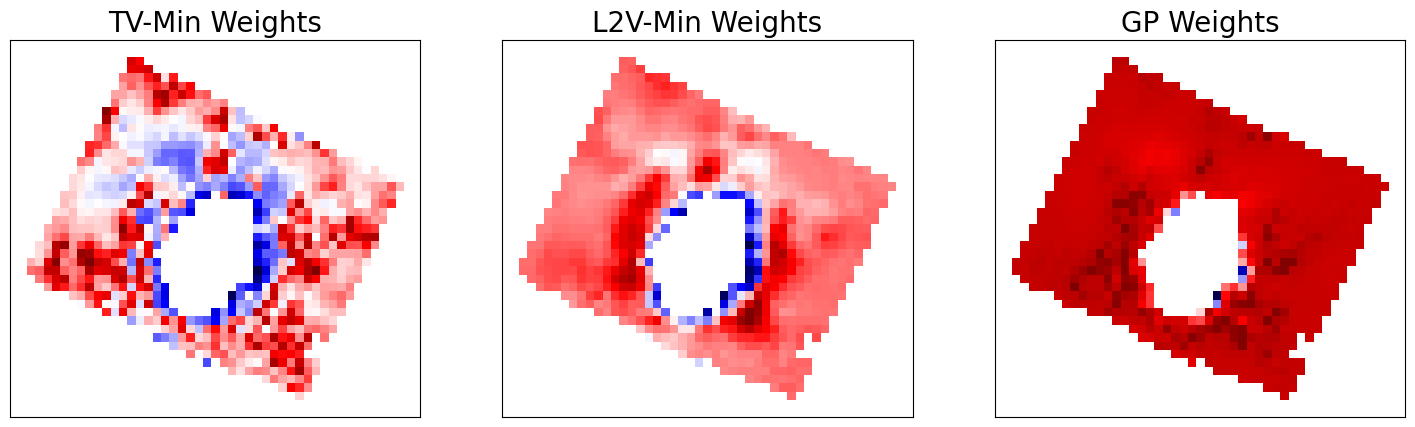

In [18]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,6))

weightmap = onp.nan*goodpix
weightmap[goodpix] = obj.softmax(tv_params)
ax1.imshow(np.log10(weightmap),cmap=plt.cm.seismic)
ax1.set_title('TV-Min Weights',fontsize=20)

weightmap = onp.nan*goodpix
weightmap[goodpix] = obj.softmax(l2v_params)
ax2.imshow(np.log10(weightmap),cmap=plt.cm.seismic)
ax2.set_title('L2V-Min Weights',fontsize=20)

weightmap = onp.nan*goodpix
weightmap[goodpix] = obj.softmax(gp_params)
ax3.imshow(np.log10(weightmap),cmap=plt.cm.seismic)
ax3.set_title('GP Weights',fontsize=20)

for ax in (ax1,ax2,ax3):
    ax.set_xticks([])
    ax.set_yticks([])

Of the three, it looks like L2V (maximum smoothness) has picked out the PSF features nicely, whereas the others have mainly modelled the background.